<a href="https://colab.research.google.com/github/havaledar/House-prices-kaggle-6100/blob/main/House_prices_categorical%20dummied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install association_metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # R-style formula api
import association_metrics as am
import re
from itertools import chain, combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3954 sha256=520fa1f69effeea1b96ae7db993c46eaa002cec901f774e82705d9256ba2bb1f
  Stored in directory: /root/.cache/pip/wheels/2d/1e/07/287b993a07cc41eade32a9b863d6d4686f985d72344a9e0911
Successfully built association-metrics


In [2]:
df_train=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/train.csv")
df_test=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/test.csv")

In [3]:
df_train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
#Dummies generated

df_train_dummy=pd.get_dummies(df_train, dummy_na=True, drop_first=True)

nan_df = df_train_dummy.loc[:, df_train_dummy.columns.str.endswith("_nan")]

pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_train_dummy.index:
    for col_nan in nan_df.columns:
        if df_train_dummy.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_train_dummy.columns[df_train_dummy.columns.str.startswith(col_id+'_')]
            df_train_dummy.loc[index, targets] = np.nan

df_train_dummy.drop(nan_df.columns, axis=1, inplace=True)

In [5]:
#Remove the variables with more than 100 NA
na_number=df_train_dummy[df_train_dummy.columns[df_train_dummy.isnull().any()]].isnull().sum()

df_train_dummy=df_train_dummy.drop(na_number[na_number > 100].index ,axis=1)

In [6]:
#filling the na with median
df_train_filled=df_train_dummy.fillna(df_train_dummy.median())
df_train_filled.isna().sum().max()

0

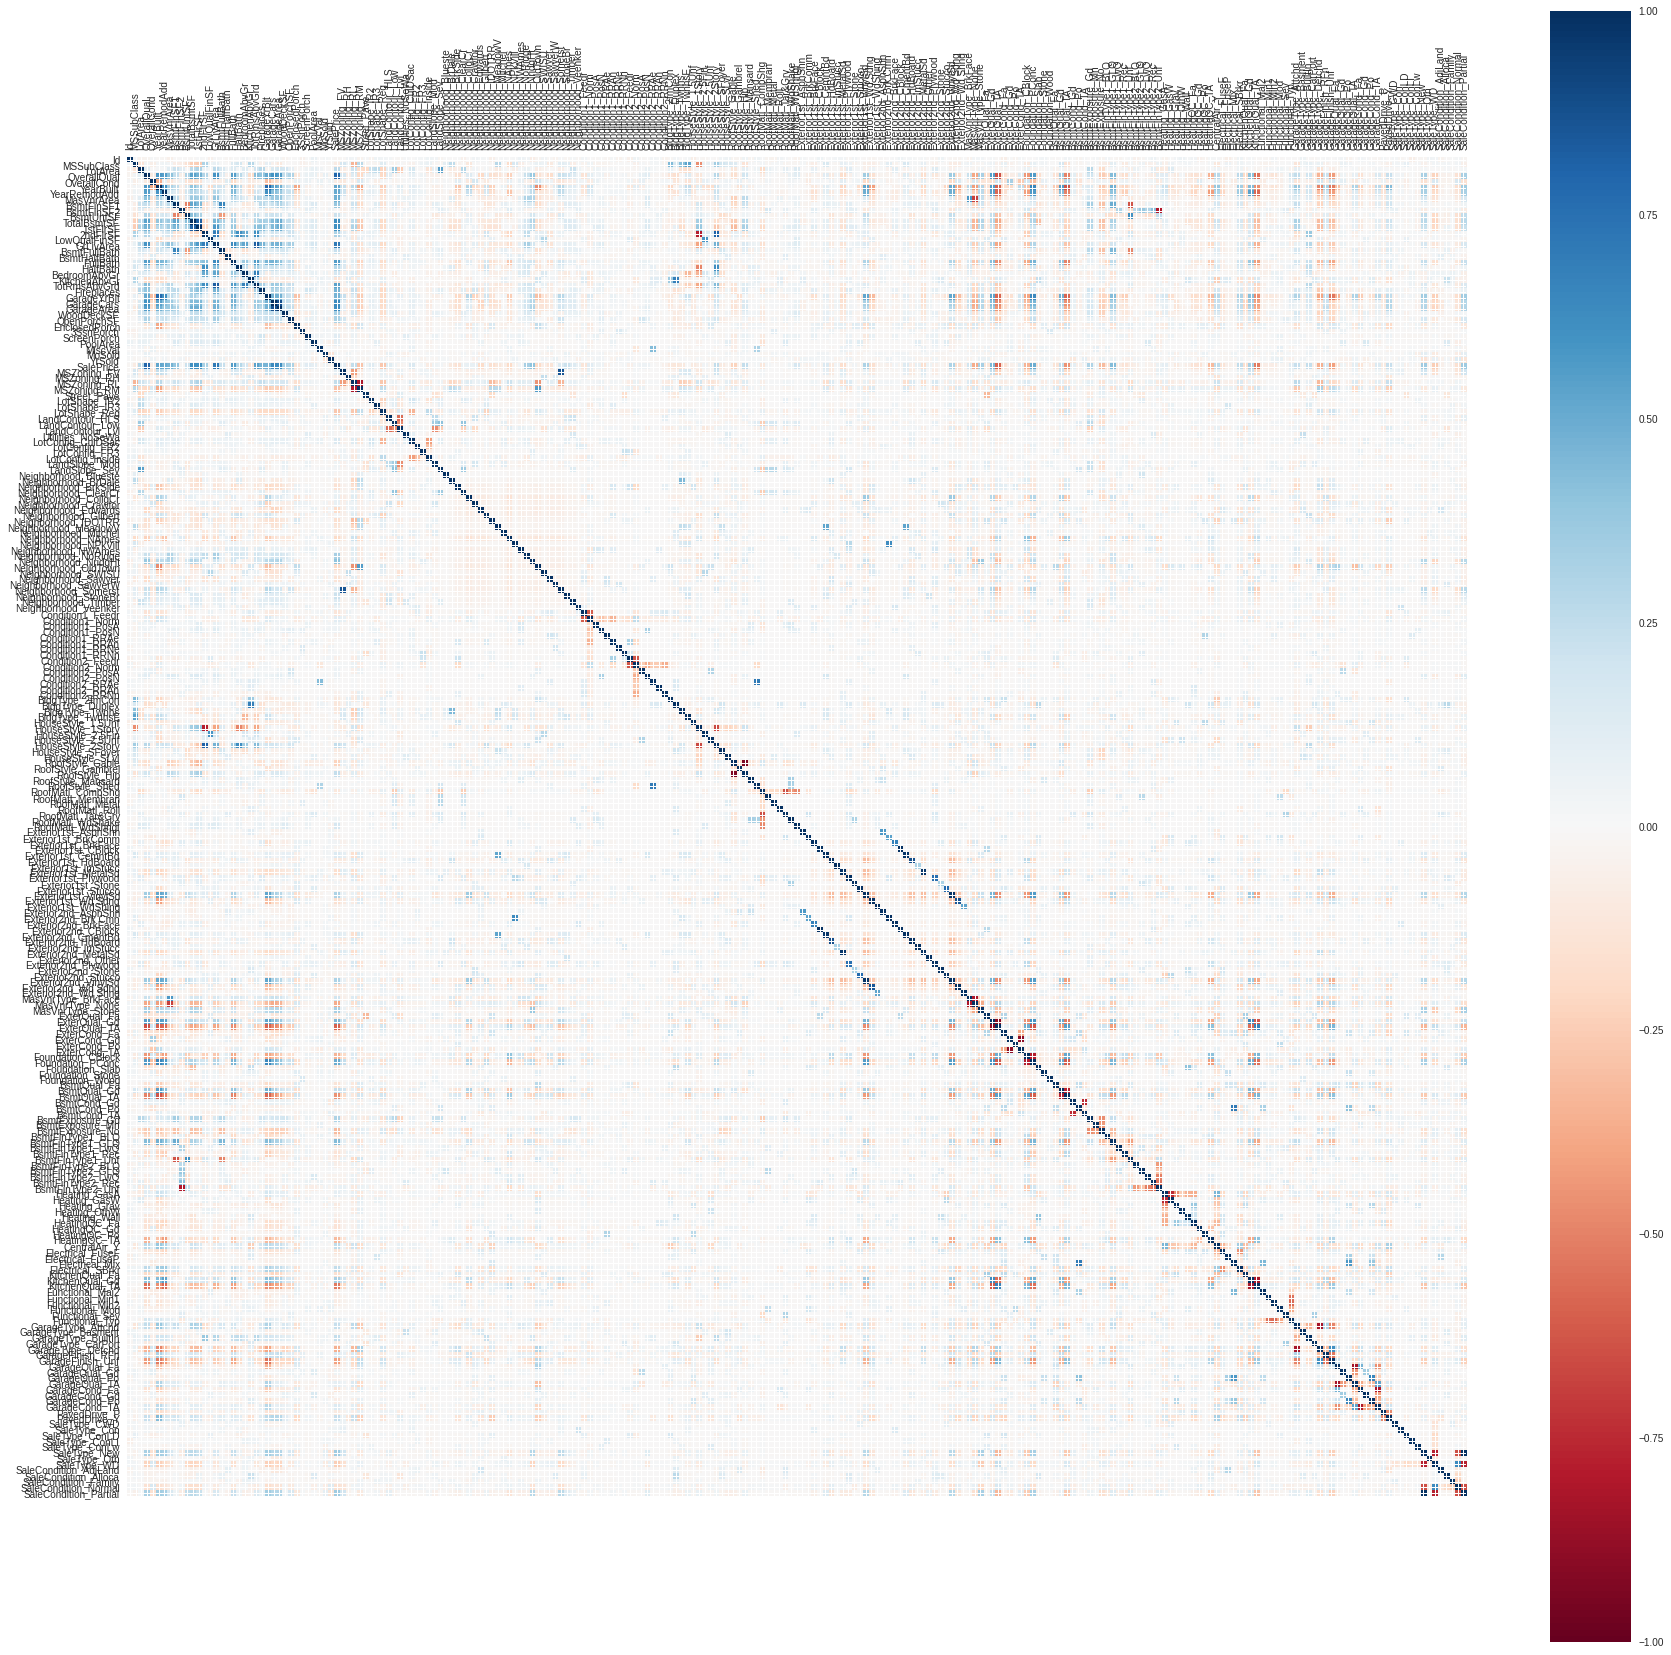

In [7]:
corr = df_train_filled.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_train_filled.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_filled.columns)
ax.set_yticklabels(df_train_filled.columns)
fig.set_size_inches(30, 30)
plt.show()

#todo: why last rows does not appear in the correlation graph and matrix

In [8]:
#todo: check if the correlation with dummies are meaningful

corr=df_train_filled.corr().abs()

#Selecting lower triangle without diagonal and removing variables with more than 50% correlations with other predictors
corr=corr.where(np.tril(np.ones(corr.shape),-1).astype(np.bool))
corr_50=corr[corr.columns[corr.max()<0.5]]
corr_50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


,Id,OverallCond,BsmtFullBath,BsmtHalfBath,Fireplaces,WoodDeckSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
Id,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
MSSubClass,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,0.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,0.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,0.03,0.04,0.02,0.10,0.05,0.04,...,0.00,0.00,0.00,NaN,NaN,NaN
SaleCondition_Alloca,0.01,0.03,0.07,0.02,0.00,0.00,...,0.01,0.01,0.00,0.00,NaN,NaN
SaleCondition_Family,0.00,0.02,0.04,0.05,0.00,0.01,...,0.01,0.01,0.01,0.01,0.01,NaN
SaleCondition_Normal,0.02,0.16,0.02,0.01,0.02,0.03,...,0.00,0.03,0.10,0.11,0.19,0.25


In [31]:
#corr_50.columns

y = df_train_filled["SalePrice"]
X = df_train_filled.loc[:,df_train_filled.columns!="SalePrice"]

In [13]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [14]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'features':feature_set, 'model':regr, 'RSS':RSS}

In [15]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print("----Models:\n----", models['features'],models['RSS'])
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [16]:
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

Streaming output truncated to the last 5000 lines.
3      [OverallQual, BsmtExposure_No, GarageCars, Gar...
4      [OverallQual, BsmtExposure_No, GarageCars, Gar...
                             ...                        
208    [OverallQual, BsmtExposure_No, GarageCars, Gar...
209    [OverallQual, BsmtExposure_No, GarageCars, Gar...
210    [OverallQual, BsmtExposure_No, GarageCars, Gar...
211    [OverallQual, BsmtExposure_No, GarageCars, Gar...
212    [OverallQual, BsmtExposure_No, GarageCars, Gar...
Name: features, Length: 213, dtype: object 0       670,117,422,846.98
1       676,030,005,761.95
2       679,180,769,539.63
3       717,405,717,348.70
4       717,456,766,628.27
              ...         
208     669,128,543,487.07
209     677,670,303,546.34
210     672,103,609,264.11
211     685,841,385,589.11
212     680,242,846,648.51
Name: RSS, Length: 213, dtype: float64
----Models:
---- 0      [OverallQual, BsmtExposure_No, GarageCars, Gar...
1      [OverallQual, BsmtExposure_No, Ga

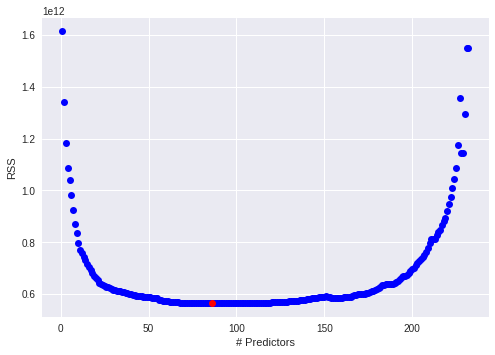

In [17]:
plt.plot(models_train['RSS'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');

In [22]:
models_train['RSS'].argmin()

86

In [23]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_full.loc[i] = forward(predictors, X, y, X, y)
    predictors = models_full.loc[i]['model'].model.exog_names

Streaming output truncated to the last 5000 lines.
3      [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
4      [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
                             ...                        
208    [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
209    [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
210    [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
211    [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
212    [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
Name: features, Length: 213, dtype: object 0     1,330,562,346,956.32
1     1,315,062,444,832.48
2     1,328,387,220,345.13
3     1,326,151,015,332.19
4     1,327,931,880,175.94
              ...         
208   1,331,111,487,461.70
209   1,330,023,904,430.91
210   1,327,100,609,244.22
211   1,322,928,736,695.05
212   1,330,584,244,191.16
Name: RSS, Length: 213, dtype: float64
----Models:
---- 0      [OverallQual, GrLivArea, YrSold, BsmtFinSF1, G...
1      [OverallQual, GrLivArea, YrSold, 

In [24]:
print(sorted(models_train.loc[86, 'model'].model.exog_names))

print(sorted(models_full.loc[86, 'model'].model.exog_names))

['3SsnPorch', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BsmtCond_Po', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'BsmtFullBath', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Electrical_FuseF', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior2nd_CmentBd', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Fireplaces', 'Foundation_Wood', 'FullBath', 'Functional_Maj2', 'Functional_Min1', 'GarageCars', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Fa', 'GarageType_Attchd', 'GarageType_CarPort', 'GarageType_Detchd', 'HalfBath', 'HeatingQC_Fa', 'HeatingQC_Gd', 'Heating_GasW', 'Heating_Wall', 'HouseStyle_1.5Unf', 'KitchenQual_TA', 'LandSlope_Mod', 'LandSlope_Sev', 'LotConfig_CulDSac', 'LotConfig_FR2', 'MSSubClass', 'MSZoning_FV', 'MSZoning_RM', 'MasVnrType_None

In [27]:
#Dummies generated

df_test_dummy=pd.get_dummies(df_test, dummy_na=True, drop_first=True)

nan_df_test = df_test_dummy.loc[:, df_test_dummy.columns.str.endswith("_nan")]

pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_test_dummy.index:
    for col_nan in nan_df_test.columns:
        if df_test_dummy.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_test_dummy.columns[df_test_dummy.columns.str.startswith(col_id+'_')]
            df_test_dummy.loc[index, targets] = np.nan

df_test_dummy.drop(nan_df_test.columns, axis=1, inplace=True)

#Remove the variables with more than 100 NA
na_number_test=df_test_dummy[df_test_dummy.columns[df_test_dummy.isnull().any()]].isnull().sum()

df_test_dummy=df_test_dummy.drop(na_number_test[na_number_test > 100].index ,axis=1)

#filling the na with median
df_test_filled=df_test_dummy.fillna(df_test_dummy.median())
df_test_filled.isna().sum().max()

#y = df_test_filled["SalePrice"]
X_test = df_test_filled.loc[:,df_test_filled.columns!="SalePrice"]

In [32]:
best_predictors=sorted(models_full.loc[86, 'model'].model.exog_names)
model_best = sm.OLS(y_train,X_train[best_predictors])
regr_best = model_best.fit()

In [39]:
best_pre_0 = [e for e in best_predictors if e not in ('Heating_OthW', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll')]
X_test_1=X_test[best_pre_0]
X_test_1['Heating_OthW'], X_test_1['RoofMatl_CompShg'], X_test_1['RoofMatl_Membran'], X_test_1['RoofMatl_Metal'], X_test_1['RoofMatl_Roll']=[0,0,0,0,0]

In [59]:
predictions = regr_best.predict(X_test_1)

In [60]:
predictions

0           -244,035,334.88
1           -170,697,711.71
2           -177,320,714.56
3           -104,535,992.42
4           -138,825,433.76
               ...         
1454          19,880,753.41
1455          21,365,360.49
1456        -272,658,009.59
1457        -120,567,415.42
1458        -100,544,518.03
Length: 1459, dtype: float64

In [63]:
predictions.to_excel("estimation.xlsx")

# Executive Summary
